# Pneumonia detection using different CNN architectures

## What is pneumonia exactly?

![image](./Pneumonia-image.jpg)


**Pneumonia** is an inflammatory condition of the lung primarily affecting the small air sacs known as alveoli. Symptoms typically include some combination of productive or dry cough, chest pain, fever and difficulty breathing. The severity of the condition is variable. Pneumonia is usually caused by infection with viruses or bacteria, and less commonly by other microorganisms. Identifying the responsible pathogen can be difficult. Diagnosis is often based on symptoms and physical examination. **Chest X-rays**, blood tests, and culture of the sputum may help confirm the diagnosis. The disease may be classified by where it was acquired, such as community- or hospital-acquired or healthcare-associated pneumonia.
Each year, pneumonia affects about 450 million people globally (7% of the population) and results in about 4 million deaths. With the introduction of antibiotics and vaccines in the 20th century, survival has greatly improved. For more details refer to the [pneumonia Wikipedia page](https://en.wikipedia.org/wiki/Pneumonia)

## What are we going to do?
In this notebook, we're going to use some of the popular CNN architectures to detect pneumonia on chest X-ray image [dataset](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia) provided by [Paul Mooney](https://www.kaggle.com/paultimothymooney) on kaggle.
We have chosen 3 architectures for this problem:
 - VGG
 - Inception
 - ResNet
 
It's important to note that a modified smaller version of each architecture is used.
## Dataset brief description

The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).

Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.

For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.

### Acknowledgements

Data: https://data.mendeley.com/datasets/rscbjbr9sj/2

License: CC BY 4.0

Citation: http://www.cell.com/cell/fulltext/S0092-8674(18)30154-5

# Importing libraries

In [122]:
# Basic libraries
import sys
import os
import time              
import pickle                
import numpy as np
import pandas as pd
from time import time

# Data visualization & printing libraries
from matplotlib import pyplot as plt
import seaborn as sb
from PIL import Image
from IPython.display import HTML, display
import tabulate

# Deep learning libraries
import tensorflow as tf
from keras import Model
from keras.models import Sequential, load_model
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from keras.layers import Flatten, Activation, Input, AveragePooling2D, Lambda, add
from keras.layers.merge import concatenate
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array
from keras.utils import plot_model

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Utility functions
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils import shuffle

# Setting random seeds
np.random.seed(7)
tf.random.set_seed(7)

# Magic functions
%matplotlib inline

## Checking that tensorflow is using GPU

To run keras models on GPU. Few things we have to check first:

1. your system has GPU (Nvidia. As AMD doesn't work yet)
2. You have installed the GPU version of tensorflow
3. You have installed CUDA [installation instructions](https://www.tensorflow.org/install/install_linux)
4. Verify that tensorflow is running with GPU [check if GPU is working](https://stackoverflow.com/questions/38009682/how-to-tell-if-tensorflow-is-using-gpu-acceleration-from-inside-python-shell)

In [2]:
# Checking that tesorflow is using the GPU

from tensorflow.python.client import device_lib 
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')),'\n')
print(device_lib.list_local_devices(),'\n')
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Num GPUs Available:  1 

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13380080817807719495
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3135687884
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11866281640678410147
physical_device_desc: "device: 0, name: GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
] 

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1



# Brief Exploratory Data Analysis

The images are stored in three main directories (train/val/test), and each directory contains 2 sub-directories, one for each class (normal/pneumonia).

First, we're going to create three datasets; train_data, val_data, and text_data. Each dataframe has two columns; image_path and label.

In [6]:
# Getting image paths and creating pandas dataframe for each dataset (train/val/test)

train_p = [('./chest_xray/chest_xray/train/PNEUMONIA/' + filename,1) for count, filename in enumerate(os.listdir('./chest_xray/chest_xray/train/PNEUMONIA'))]
train_n = [('./chest_xray/chest_xray/train/NORMAL/' + filename,0) for count, filename in enumerate(os.listdir('./chest_xray/chest_xray/train/NORMAL'))]
val_p = [('./chest_xray/chest_xray/val/PNEUMONIA/' + filename,1) for count, filename in enumerate(os.listdir('./chest_xray/chest_xray/val/PNEUMONIA'))]
val_n = [('./chest_xray/chest_xray/val/NORMAL/' + filename,0) for count, filename in enumerate(os.listdir('./chest_xray/chest_xray/val/NORMAL'))]
test_p = [('./chest_xray/chest_xray/test/PNEUMONIA/' + filename,1) for count, filename in enumerate(os.listdir('./chest_xray/chest_xray/test/PNEUMONIA'))]
test_n = [('./chest_xray/chest_xray/test/NORMAL/' + filename,0) for count, filename in enumerate(os.listdir('./chest_xray/chest_xray/test/NORMAL'))]

train_data = pd.DataFrame(train_p+train_n, columns=['image_path', 'label'],index=None)
val_data = pd.DataFrame(val_p+val_n, columns=['image_path', 'label'],index=None)
test_data = pd.DataFrame(test_p+test_n, columns=['image_path', 'label'],index=None)

In [4]:
print("The head of the training dataframe:")
train_data.head()

The head of the training dataframe:


,image,label
0,./chest_xray/chest_xray/train/PNEUMONIA/person...,1
1,./chest_xray/chest_xray/train/PNEUMONIA/person...,1
2,./chest_xray/chest_xray/train/PNEUMONIA/person...,1
3,./chest_xray/chest_xray/train/PNEUMONIA/person...,1
4,./chest_xray/chest_xray/train/PNEUMONIA/person...,1


Now, let's check the dataset balance. To do that we're going to plot the count of images for each class in each dataframe.

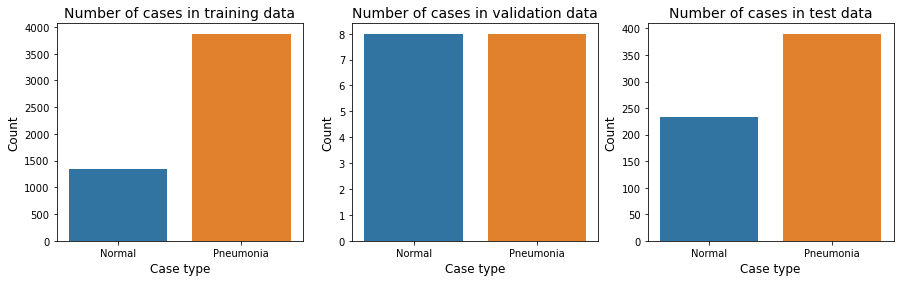

In [5]:
# Count plot of the class representations.

plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
sb.countplot(data= train_data, x='label')
plt.title('Number of cases in training data', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(train_data.label.unique())), ['Normal', 'Pneumonia'])

plt.subplot(1,3,2)
sb.countplot(data= val_data, x='label')
plt.title('Number of cases in validation data', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(val_data.label.unique())), ['Normal', 'Pneumonia'])

plt.subplot(1,3,3)
sb.countplot(data= test_data, x='label')
plt.title('Number of cases in test data', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(test_data.label.unique())), ['Normal', 'Pneumonia']);

Balance issues:

    1- Very inbalanced representation of classes in the training data.
    2- Insufficient number of validation images.
    3- Slight imbalance between the two classes classes.

Second, let's check the size and format of the images.

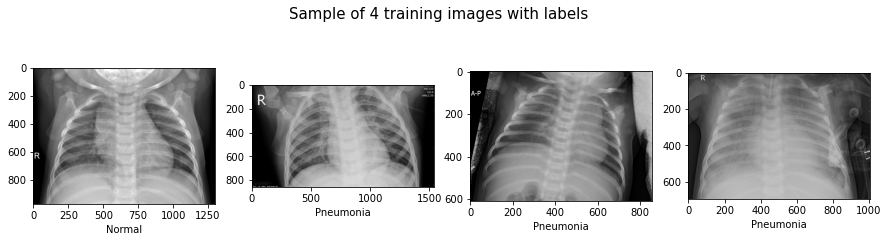

In [6]:
# Visualizing a sample of 4 training images.

random_imgs = np.random.randint(1,train_data.shape[0],4)
plt.figure(figsize=(15,4))
plt.suptitle('Sample of 4 training images with labels', y=0.95,fontsize=15)
for i, img in enumerate(train_data.iloc[random_imgs,0]):
    image_temp = Image.open(img)                                           # Conversion to Black & White
    plt.subplot(1,4,i+1)
    plt.imshow(image_temp, cmap='gray')
    if train_data.iloc[random_imgs[i],1] == 0:
        plt.xlabel('Normal')
    else:
        plt.xlabel('Pneumonia')

Now that we know the images we have comes in different shapes, let's inspect their format.

In [7]:
# Creating a dataframe for image properties. 

l=[]
path_list=train_p+train_n+val_p+val_n+test_p+test_n
for i in path_list:
    with Image.open(i[0]) as image_temp:
        l.append(list(np.asarray(image_temp).shape))
imgs_size_df = pd.DataFrame(l, columns=['height', 'width','channels'],index=None)

Image size: (307, 502, 3)


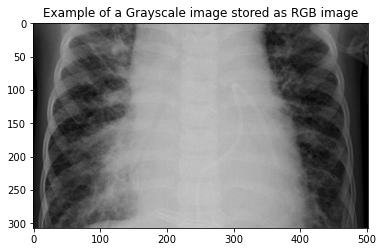

In [9]:
# Example of B&W image stored in RGB format

img = Image.open(path_list[imgs_size_df.query('channels==3').index[0]][0])
plt.imshow(img)
plt.title('Example of a Grayscale image stored as RGB image')
print('Image size:', np.asarray(img).shape)

There are some images stored in a RGB format where in fact they are black and white, this could be done if the three channels are identical, however maintaining this representation wouldn't be efficient since we're using more memory than necessary. Also, the reason we need the convert RGB images to B&W in this task is because the input data to a CNN need to have a consistent shape, in our case 1 channel instead of 3.

Below we can see the representation of the trainig set images in a scatter plot in function of their width, hight and number of channel.

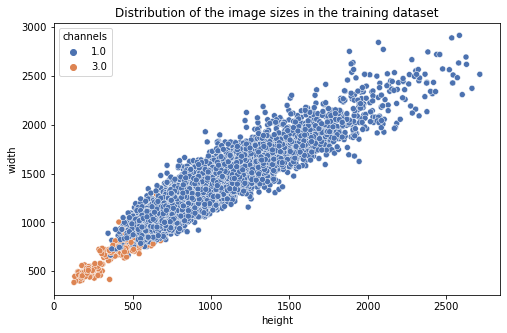

In [10]:
plt.figure(figsize=(8,5))
sb.scatterplot(data=imgs_size_df, x='height', y='width', hue='channels', palette="deep")
plt.title('Distribution of the image sizes in the training dataset');

 Since, it's not clear enough that the majority of the images have only 1 channel, let's calculate how many images in the whole set of data have in fact 3 channels.

In [8]:
imgs_size_df.fillna(value=int(1), inplace=True)
imgs_size_df.query('channels==3').head()
print('There are', imgs_size_df.query('channels==3').shape[0], 'B&W images stored in RGB format.')

There are 283 B&W images stored in RGB format


# Data Pre-processing

## Resizing
To begin the pre-processing step, we're going to resize all the images to a smaller size that would be acceptable to train on a local machine.

After some attempts, I found that 256x256x1 is a good size to use. Here's a [Quora answer](https://www.quora.com/To-what-resolution-should-I-resize-my-images-to-use-as-training-dataset-for-deep-learning) that I found helpful for me to chose the image size.

The new resized imaged will be stored in new directories, so that we can have the older version of our data.

In [11]:
# Resizing all the images: New size 256x256

direct_lists=[train_p,train_n,val_p,val_n,test_p,test_n]
save_paths=['./chest_xray/modified/train/PNEUMONIA/',
            './chest_xray/modified/train/NORMAL/',
            './chest_xray/modified/val/PNEUMONIA/',
            './chest_xray/modified/val/NORMAL/',
            './chest_xray/modified/test/PNEUMONIA/',
            './chest_xray/modified/test/NORMAL/']
save_prefix=['train_pneumonial','train_normal','val_pneumonial','val_normal','test_pneumonial','test_normal']
for direct,save_path,prefix in zip(direct_lists,save_paths, save_prefix):
    i=1
    for path in direct:
        with Image.open(path[0]) as img_temp:
            resized_gray = img_temp.resize((256,256)).convert('L')
            resized_gray.save(save_path+prefix+'_'+str(i)+'.jpg')
        i+=1

In [3]:
# Modified image paths

train_p = [('./chest_xray/modified/train/PNEUMONIA/' + filename,1) for count, filename in enumerate(os.listdir('./chest_xray/modified/train/PNEUMONIA'))]
train_n = [('./chest_xray/modified/train/NORMAL/' + filename,0) for count, filename in enumerate(os.listdir('./chest_xray/modified/train/NORMAL'))]
val_p = [('./chest_xray/modified/val/PNEUMONIA/' + filename,1) for count, filename in enumerate(os.listdir('./chest_xray/modified/val/PNEUMONIA'))]
val_n = [('./chest_xray/modified/val/NORMAL/' + filename,0) for count, filename in enumerate(os.listdir('./chest_xray/modified/val/NORMAL'))]
test_p = [('./chest_xray/modified/test/PNEUMONIA/' + filename,1) for count, filename in enumerate(os.listdir('./chest_xray/modified/test/PNEUMONIA'))]
test_n = [('./chest_xray/modified/test/NORMAL/' + filename,0) for count, filename in enumerate(os.listdir('./chest_xray/modified/test/NORMAL'))]

train_data = pd.DataFrame(train_p+train_n, columns=['image', 'label'],index=None)
val_data = pd.DataFrame(val_p+val_n, columns=['image', 'label'],index=None)
test_data = pd.DataFrame(test_p+test_n, columns=['image', 'label'],index=None)

Checking that all the images are resized correctly.

In [13]:
l=[]
paths = train_p+train_n+val_p+val_n+test_p+test_n
for i in paths:
    with Image.open(i[0]) as image_temp:
        l.append(list(np.asarray(image_temp).shape))
imgs_size_df = pd.DataFrame(l, columns=['height', 'width'],index=None)

In [14]:
print('All the images are now of size',imgs_size_df.height.value_counts().index[0],
      'x',imgs_size_df.width.value_counts().index[0],'x 1')

All the images are now of size 256 x 256 x 1


## Data Augmentation

Data augmentation is a well-known and a powerful way to address the lack of data problem. In our case, we can use data augmentation to restore the class balance in the training dataset, and to enlarge the validation dataset.

The process of iamge data augmentation is basically creating copies of the images we already have and applying some sorts of modifications to them so that they would look as if they're new images that have the same labels as the old ones.
Example of the modifications that we could apply:

    - Zooming
    - Rotating
    - Fliping
    - Modifying brightness
    .
    .
More details about data augmentation can be found [here](https://nanonets.com/blog/data-augmentation-how-to-use-deep-learning-when-you-have-limited-data-part-2/).

In our case we're chosing to:

 - Rotate the images with 10°
 - Modifty the brightness by 10%
 - Zoom in/out by 15%
 - Apply height/width shift within a range of 10%
 
We're chosing to not apply any sort of flip and that is because in reality the X-ray images would not come in flipped form (mirrored).

In [11]:
# Creating an image generator

ImageGen = ImageDataGenerator(
    rotation_range=10,
    brightness_range=[0.9,1.1],
    zoom_range = 0.15,
    width_shift_range=0.1, 
    height_shift_range=0.1,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest"
)

In [7]:
# Function that generates and save images by batch and up to a certain threshold.

def GenerateImages(data, save_dir, b_size, max_size):
    img_array_list=[]
    for path in data:
        with Image.open(path[0]) as image_temp:
            img_array = img_to_array(image_temp)
            img_array = img_array.reshape((1,)+img_array.shape)
            img_array_list.append(img_array)
    img_array_list = np.concatenate(img_array_list, axis=0)
    i=0
    for batch in ImageGen.flow(img_array_list, batch_size=b_size,
                            save_to_dir='./chest_xray/modified/'+save_dir,
                            save_prefix='Aug', save_format='JPEG'):
        i+=1
        if i>(max_size-len(data))//b_size:
            break

In [20]:
# Generating train and validation data

GenerateImages(train_p, 'train/AUGMENTED/PNEUMONIA', 16, 8000)
GenerateImages(train_n, 'train/AUGMENTED/NORMAL', 16, 8000)
GenerateImages(val_p, 'val/AUGMENTED/PNEUMONIA', 8, 400)
GenerateImages(val_n, 'val/AUGMENTED/NORMAL', 8, 400)

I've chosen to save the generated images then use them so that I can make sure that the three CNN models will use the exactly same data.

In [4]:
# Getting the augmented data paths and adding them to the old ones

train_p_aug = [('./chest_xray/modified/train/AUGMENTED/PNEUMONIA/' + filename,1) for count, filename in enumerate(os.listdir('./chest_xray/modified/train/AUGMENTED/PNEUMONIA'))]
train_p = train_p + train_p_aug
train_n_aug = [('./chest_xray/modified/train/AUGMENTED/NORMAL/' + filename,0) for count, filename in enumerate(os.listdir('./chest_xray/modified/train/AUGMENTED/NORMAL'))]
train_n = train_n + train_n_aug

val_p_aug = [('./chest_xray/modified/val/AUGMENTED/PNEUMONIA/' + filename,1) for count, filename in enumerate(os.listdir('./chest_xray/modified/val/AUGMENTED/PNEUMONIA'))]
val_p = val_p + val_p_aug
val_n_aug = [('./chest_xray/modified/val/AUGMENTED/NORMAL/' + filename,0) for count, filename in enumerate(os.listdir('./chest_xray/modified/val/AUGMENTED/NORMAL'))]
val_n = val_n + val_n_aug

Now, let's check that the images are generated correctly and that we have balanced the classes in the training dataset.

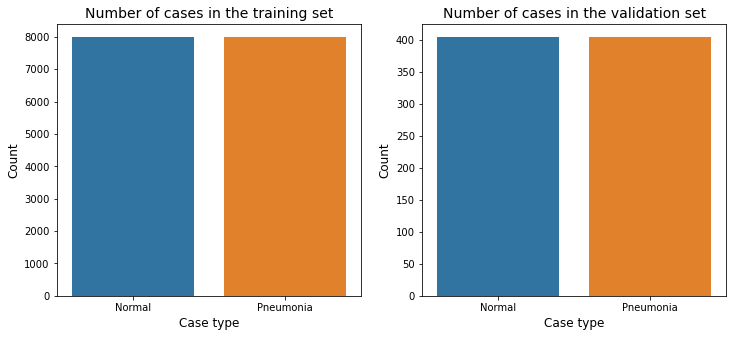

In [6]:
train_data = pd.DataFrame(train_p+train_n, columns=['image', 'label'],index=None)
val_data = pd.DataFrame(val_p+val_n, columns=['image', 'label'],index=None)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sb.countplot(data= train_data, x='label')
plt.title('Number of cases in the training set', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(train_data.label.unique())), ['Normal', 'Pneumonia'])

plt.subplot(1,2,2)
sb.countplot(data= val_data, x='label')
plt.title('Number of cases in the validation set', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(train_data.label.unique())), ['Normal', 'Pneumonia']);

## Converting to arrays

The final step of pre-processing is converting the images into numpy arrays, then normalize and shuffle them so that they're ready to use in keras sequential models.

In [5]:
Train_data=[]
Train_label=[]
for path in train_n+train_p:
    with Image.open(path[0]) as image_temp:
        img_array = img_to_array(image_temp)
        img_array = (img_array-img_array.mean())/img_array.std()
        img_array = img_array.reshape((1,)+img_array.shape)
        Train_data.append(img_array)
    Train_label.append(path[1])
Train_data = np.concatenate(Train_data, axis=0)

Val_data=[]
Val_label=[]
for path in val_n+val_p:
    with Image.open(path[0]) as image_temp:
        img_array = img_to_array(image_temp)
        img_array = (img_array-img_array.mean())/img_array.std()
        img_array = img_array.reshape((1,)+img_array.shape)
        Val_data.append(img_array)
    Val_label.append(path[1])
Val_data = np.concatenate(Val_data, axis=0)

Test_data=[]
Test_label=[]
for path in test_n+test_p:
    with Image.open(path[0]) as image_temp:
        img_array = img_to_array(image_temp)
        img_array = (img_array-img_array.mean())/img_array.std()
        img_array = img_array.reshape((1,)+img_array.shape)
        Test_data.append(img_array)
    Test_label.append(path[1])
Test_data = np.concatenate(Test_data, axis=0)

In [6]:
Train_data, Train_label = shuffle(Train_data, Train_label, random_state=7)
Val_data, Val_label = shuffle(Val_data, Val_label, random_state=7)
Test_data, Test_label = shuffle(Test_data, Test_label, random_state=7)

# CNN Models

We're going to build all the CNN models in this section using the Keras API.

# VGG architecture

The VGG convolutional neural network is one of the most famous CNNs. It was introduced by Simonyan and Zisserman in their 2014 paper, [Very Deep Convolutional Networks for Large Scale Image Recognition](https://arxiv.org/abs/1409.1556). It has a simple architecture mainly characterized by:

 - The use of 3x3 filters only.
 - The increasing of number of filters as the network goes deeper (64-128-256-512).
 - The use of the ReLU activation function.
 - The use of MaxPooling to reduce the volume size.
 - The convolutional layers use a 'same' padding and strides of 1.
 
Although, the most famous VGG networks are the VGG-16 and the VGG-19 which contatins respectively 16 and 19 layers. We're going to implement a smaller version considering the available computational power.

In our VGG model we're going to use a He Normal initialization for the convolutional layes. We added dropout to control the overfitting of the model.
The total number of layers are 9, where the last two layer are fully connected and the output layer contains a single sigmoid unit. 

The full architecture can be visualized in the following summary table or the image below it.

In [75]:
VGG_model = Sequential(name='VGG_model')
VGG_model.add(Conv2D(16,(3,3), strides=1, padding='same', activation='relu', kernel_initializer='he_normal',
                       input_shape=(256,256,1) ))
VGG_model.add(MaxPooling2D((2,2), padding='same'))

VGG_model.add(Conv2D(32,(3,3), strides=1, padding='same', activation='relu', kernel_initializer='he_normal' ))
VGG_model.add(Conv2D(32,(3,3), strides=1, padding='same', activation='relu', kernel_initializer='he_normal' ))
VGG_model.add(BatchNormalization())
VGG_model.add(MaxPooling2D((2,2), strides=2 ,padding='same'))

VGG_model.add(Conv2D(64,(3,3), strides=1, padding='same', activation='relu', kernel_initializer='he_normal' ))
VGG_model.add(Conv2D(64,(3,3), strides=1, padding='same', activation='relu', kernel_initializer='he_normal' ))
VGG_model.add(BatchNormalization())
VGG_model.add(MaxPooling2D((2,2), strides=2 ,padding='same'))

VGG_model.add(Conv2D(128,(3,3), strides=1, padding='same', activation='relu', kernel_initializer='he_normal' ))
VGG_model.add(Conv2D(128,(3,3), strides=1, padding='same', activation='relu', kernel_initializer='he_normal' ))
VGG_model.add(BatchNormalization())
VGG_model.add(MaxPooling2D((2,2), strides=2 ,padding='same'))

VGG_model.add(Flatten())

VGG_model.add(Dense(8, activation='relu', kernel_initializer='he_normal'))
VGG_model.add(Dropout(0.35))
VGG_model.add(Dense(1, activation="sigmoid"))

#optimizer = Adam(lr=0.0001, decay=1e-4)
VGG_model.compile(optimizer = 'adam', loss='binary_crossentropy', metrics=['accuracy'])

VGG_model.summary()

Model: "VGG_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_227 (Conv2D)          (None, 256, 256, 16)      160       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_228 (Conv2D)          (None, 128, 128, 32)      4640      
_________________________________________________________________
conv2d_229 (Conv2D)          (None, 128, 128, 32)      9248      
_________________________________________________________________
batch_normalization_11 (Batc (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_230 (Conv2D)          (None, 64, 64, 64)        18

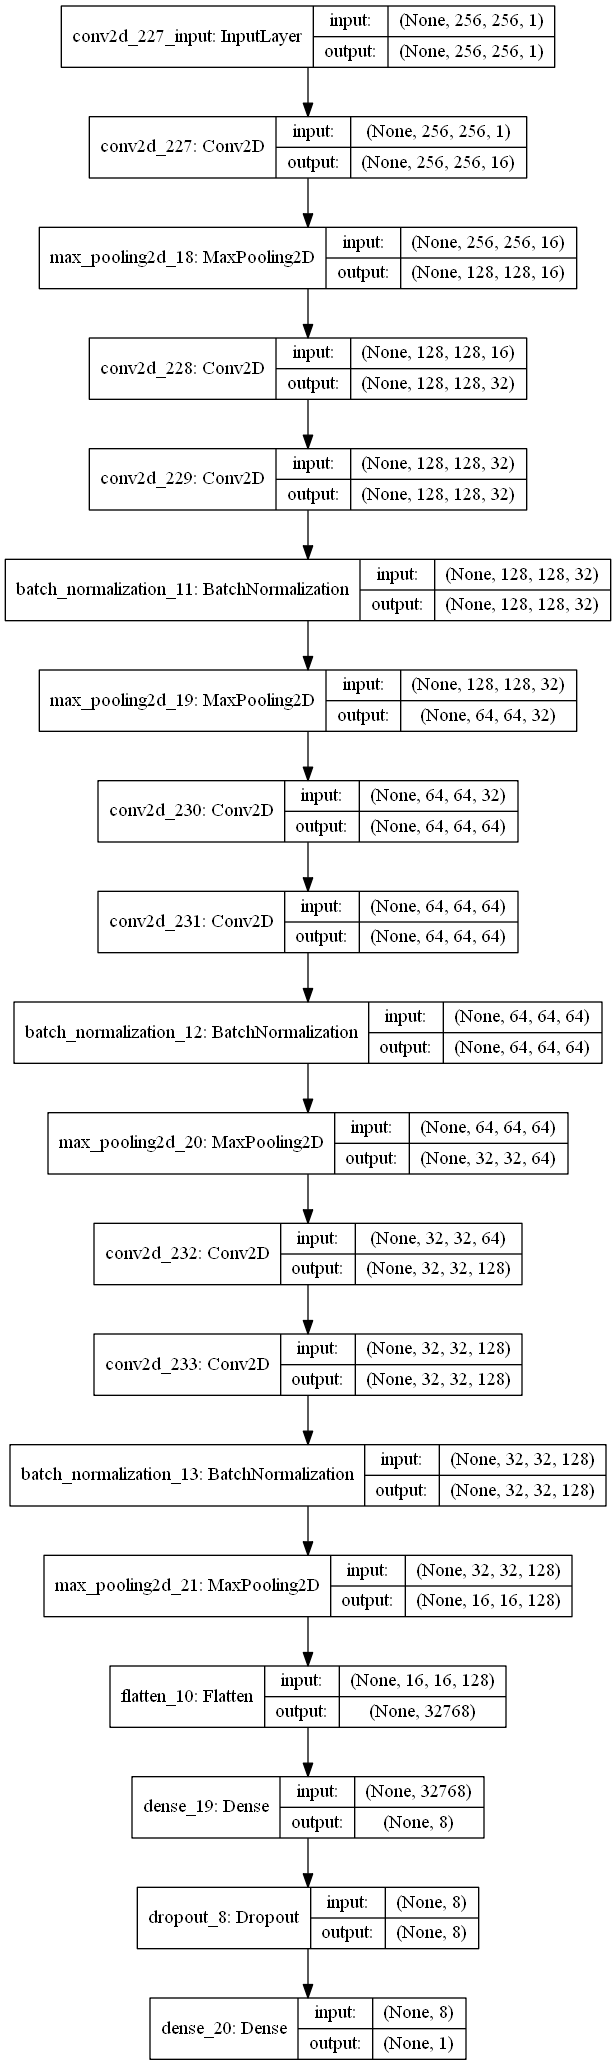

In [76]:
plot_model(VGG_model, show_shapes=True, to_file='VGG_model.png')

After some tuning of the hyper parameters, we've found that the follwoing ones gave the best results.

In [77]:
callback = ReduceLROnPlateau(monitor='val_loss', patience = 3, cooldown=0, verbose=1, factor=0.6, min_lr=0.000001)
start_vgg = time()
VGG_results = VGG_model.fit(
    x=Train_data,
    y=Train_label,
    batch_size=16,
    validation_data=(Val_data,Val_label),
    class_weight={0:12, 1:0.5},
    epochs=40, callbacks=[callback])
end_vgg = time()
vgg_train_dur = end_vgg - start_vgg

Train on 15986 samples, validate on 810 samples
Epoch 1/40
15986/15986 [==============================] - 116s 7ms/step - loss: 0.7511 - accuracy: 0.5123 - val_loss: 0.7182 - val_accuracy: 0.5000
Epoch 2/40
15986/15986 [==============================] - 113s 7ms/step - loss: 0.6779 - accuracy: 0.5104 - val_loss: 1.4584 - val_accuracy: 0.5000
Epoch 3/40
15986/15986 [==============================] - 114s 7ms/step - loss: 0.5486 - accuracy: 0.5028 - val_loss: 0.9047 - val_accuracy: 0.5000
Epoch 4/40
15986/15986 [==============================] - 114s 7ms/step - loss: 0.5313 - accuracy: 0.5083 - val_loss: 0.8640 - val_accuracy: 0.5309

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.
Epoch 5/40
15986/15986 [==============================] - 114s 7ms/step - loss: 0.5225 - accuracy: 0.5550 - val_loss: 0.6741 - val_accuracy: 0.5086
Epoch 6/40
15986/15986 [==============================] - 114s 7ms/step - loss: 0.4782 - accuracy: 0.5978 - val_loss: 0.6824 - val_

In [78]:
# Saving/loading the VGG trained model

VGG_model.save('./VGG_model.h5')
with open('VGG_results.pickle', 'wb') as file:
    pickle.dump(VGG_results, file)

# Load the VGG trained model

VGG_model = load_model('./VGG_model.h5')
with open('VGG_results.pickle', 'rb') as file:
     VGG_results = pickle.load(file)

### Results

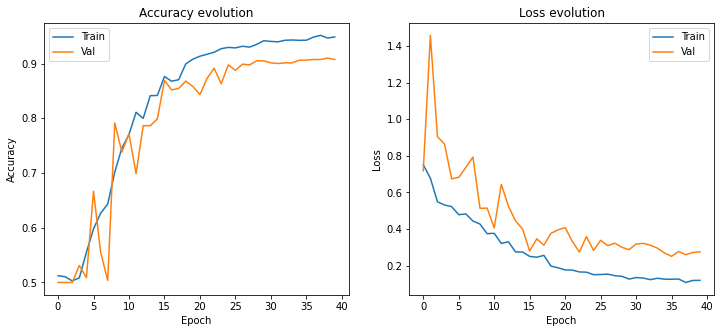

In [79]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(VGG_results.history['accuracy'])
plt.plot(VGG_results.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train','Val'])
plt.title('Accuracy evolution')

plt.subplot(122)
plt.plot(VGG_results.history['loss'])
plt.plot(VGG_results.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train','Val'])
plt.title('Loss evolution');

In [80]:
print('Classification report:')
VGG_pred = VGG_model.predict(Test_data)
print(classification_report(VGG_pred.round(),Test_label))

Classification report:
              precision    recall  f1-score   support

         0.0       0.71      0.95      0.82       175
         1.0       0.98      0.85      0.91       449

    accuracy                           0.88       624
   macro avg       0.85      0.90      0.86       624
weighted avg       0.90      0.88      0.88       624



# Inception architecture

The Inception-v1, which was named also GoogLeNet, was the winners of the (ImageNet Large Scale Visual Recognition Competition) of 2014. 

In their [paper](https://arxiv.org/abs/1409.4842), Christian Szegedy et al. introduced the first version of the Inception architecture, and mentioned that the chosen name "Inception" was motivated by the famous internet meme of the Inception movie captionned "We need to go deeper".

Briefly, the Inception architecture mainly differ from the previous architecture such as the VGG, which was the runner-up in the ILSVRC 2014 competition, ZFNet, and AlexNet in the geometrical relation between layers. The inception architecture introducesd the inception module which uses multiple convolutional layers parallelly and then concatenate their outputs.
One main difference worth mentionning is the use of a global average pooling. More details about the Inception architecture can be found [here](https://medium.com/coinmonks/paper-review-of-googlenet-inception-v1-winner-of-ilsvlc-2014-image-classification-c2b3565a64e7).

The following model is a simpler and non-deep version of the inception network, using only 2 inception modules.

In [56]:
# Creating the inception module

def inception_module(layer_input, fb1, fb2_in, fb2_out, fb3_in, fb3_out, fb4_out):

    conv1 = Conv2D(fb1, (1,1), padding='same', activation='relu', kernel_initializer='he_normal')(layer_input)

    conv3 = Conv2D(fb2_in, (1,1), padding='same', activation='relu', kernel_initializer='he_normal')(layer_input)
    conv3 = Conv2D(fb2_out, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')(conv3)

    conv5 = Conv2D(fb3_in, (1,1), padding='same', activation='relu', kernel_initializer='he_normal')(layer_input)
    conv5 = Conv2D(fb3_out, (5,5), padding='same', activation='relu', kernel_initializer='he_normal')(conv5)

    pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_input)
    pool = Conv2D(fb4_out, (1,1), padding='same', activation='relu', kernel_initializer='he_normal')(pool)

    layer_output = concatenate([conv1, conv3, conv5, pool], axis=-1)
    return layer_output

**Note:** Inception architecture uses local response normalisation instead of batch normalization after the first convolutional layer. More details about the difference between the two types of normalizations can be found [here](https://towardsdatascience.com/difference-between-local-response-normalization-and-batch-normalization-272308c034ac).

This can be achieved using the Keras lambda layer ad the tensorflow local_responce_normalization function.

In [57]:
visible = Input(shape=(256,256,1))

layer = Conv2D(32, (7,7), strides=2, padding='same', activation='relu', kernel_initializer='he_normal' )(visible)
layer = MaxPooling2D((3,3), strides=(2,2))(layer)
layer = Lambda(tf.nn.local_response_normalization)(layer)
layer = Conv2D(32, (3,3), strides=1, padding='same', activation='relu', kernel_initializer='he_normal' )(layer)
layer = MaxPooling2D((3,3), strides=(2,2))(layer)
layer = inception_module(layer, 32, 64, 64, 16, 32, 32)
layer = inception_module(layer, 32, 64, 64, 16, 32, 32)
layer = MaxPooling2D((3,3), strides=(2,2), padding='same')(layer)
layer = Conv2D(32, (3,3), strides=1, padding='same', activation='relu', kernel_initializer='he_normal' )(layer)
layer = AveragePooling2D((3,3), padding='valid')(layer)
layer = Flatten()(layer)
layer = Dense(4, activation='relu', kernel_initializer='he_normal')(layer)
layer = Dense(1, activation='sigmoid')(layer)

Inception_model = Model(inputs=visible, outputs=layer, name='Inception_model')

Inception_model.summary()


Model: "Inception_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_212 (Conv2D)             (None, 128, 128, 32) 1600        input_9[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_13 (MaxPooling2D) (None, 63, 63, 32)   0           conv2d_212[0][0]                 
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 63, 63, 32)   0           max_pooling2d_13[0][0]           
____________________________________________________________________________________

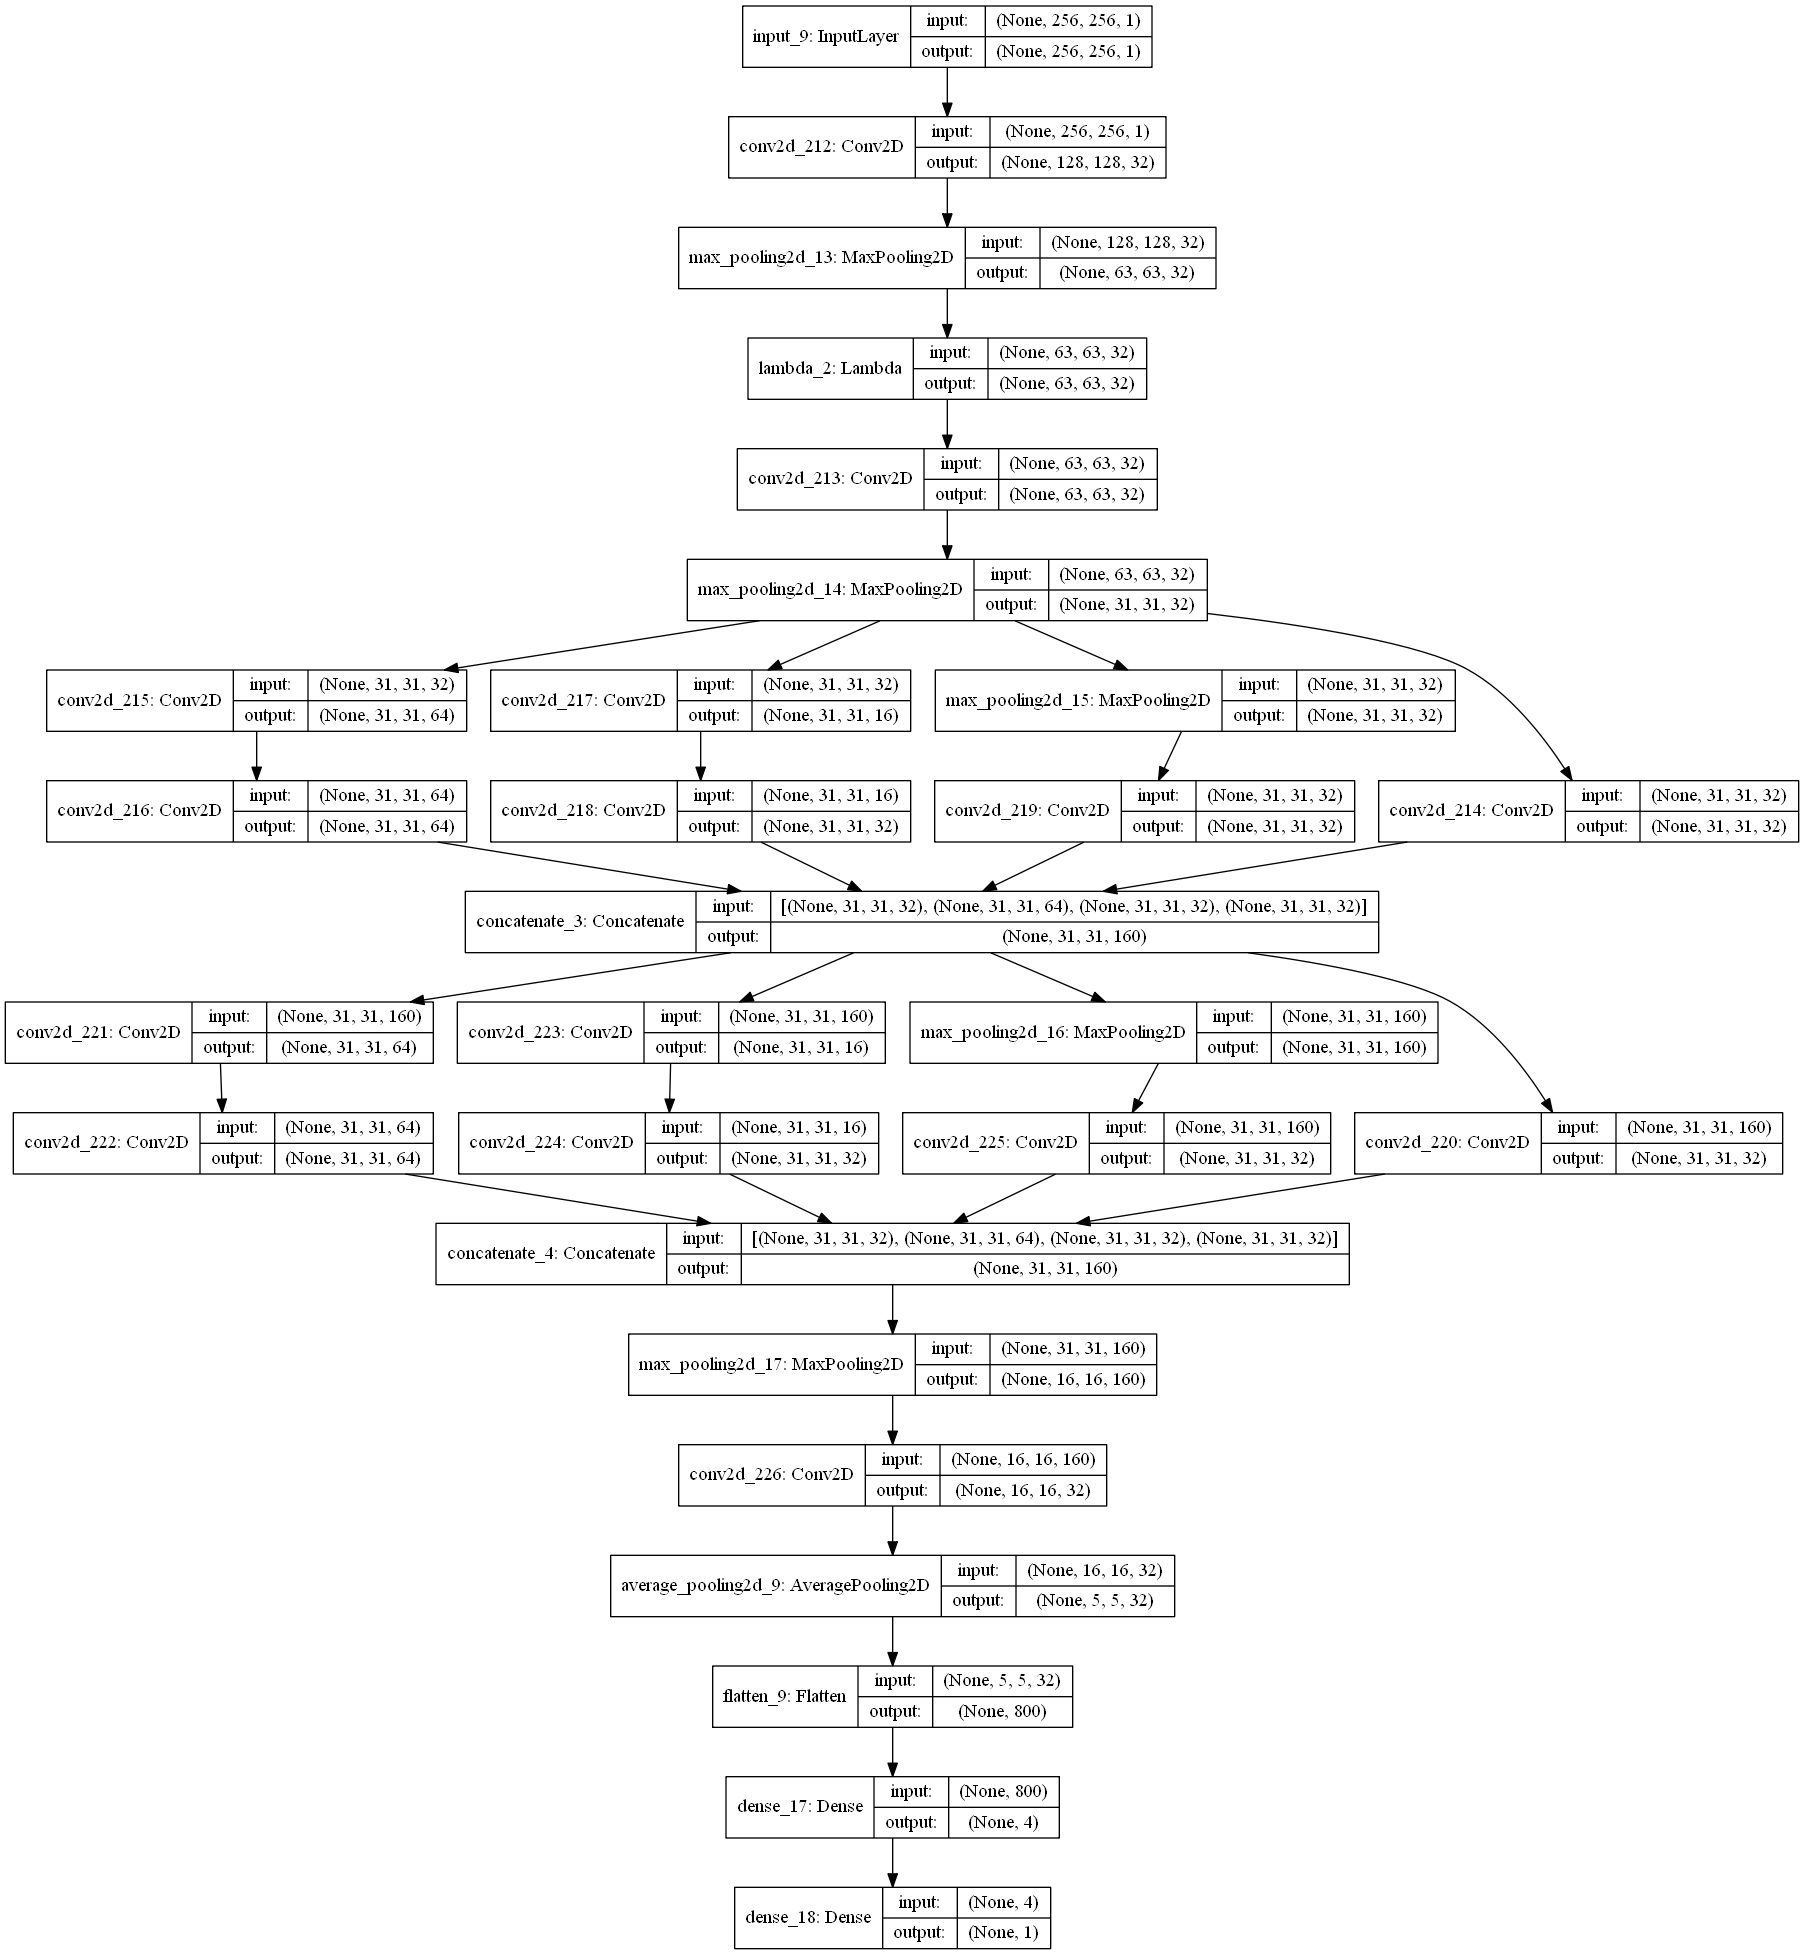

In [58]:
plot_model(Inception_model, show_shapes=True, to_file='inception_module.png')

In [59]:
Inception_model.compile(optimizer = 'adam', loss='binary_crossentropy', metrics=['accuracy'])
callback = ReduceLROnPlateau(monitor='val_loss', patience = 3, cooldown=0, verbose=1, factor=0.6, min_lr=0.000001)
start_inception = time()
results_inception = Inception_model.fit(
    x=Train_data,
    y=Train_label,
    batch_size=16,
    validation_data=(Val_data,Val_label),
    class_weight={0:12, 1:0.5},
    epochs=20, callbacks=[callback])
end_inception = time()
inception_train_dur = end_inception - start_inception

Train on 15986 samples, validate on 810 samples
Epoch 1/20
15986/15986 [==============================] - 49s 3ms/step - loss: 0.5102 - accuracy: 0.7458 - val_loss: 1.1545 - val_accuracy: 0.6025
Epoch 2/20
15986/15986 [==============================] - 48s 3ms/step - loss: 0.3231 - accuracy: 0.8698 - val_loss: 0.5654 - val_accuracy: 0.7914
Epoch 3/20
15986/15986 [==============================] - 48s 3ms/step - loss: 0.2870 - accuracy: 0.8908 - val_loss: 0.4620 - val_accuracy: 0.8074
Epoch 4/20
15986/15986 [==============================] - 48s 3ms/step - loss: 0.2189 - accuracy: 0.9054 - val_loss: 0.3386 - val_accuracy: 0.8679
Epoch 5/20
15986/15986 [==============================] - 48s 3ms/step - loss: 0.1909 - accuracy: 0.9191 - val_loss: 0.8719 - val_accuracy: 0.7000
Epoch 6/20
15986/15986 [==============================] - 49s 3ms/step - loss: 0.1723 - accuracy: 0.9230 - val_loss: 0.3006 - val_accuracy: 0.8753
Epoch 7/20
15986/15986 [==============================] - 48s 3ms/step

In [88]:
# Saving the Inception trained model

Inception_model.save('./inception_model.h5')

with open('results_inception.pickle', 'wb') as file:
    pickle.dump(results_inception, file)

# Load the Inception trained model

#Inception_model = load_model('./inception_model.h5')

#with open('results_inception.pickle', 'rb') as file:
#     results_inception = pickle.load(file)

### Results

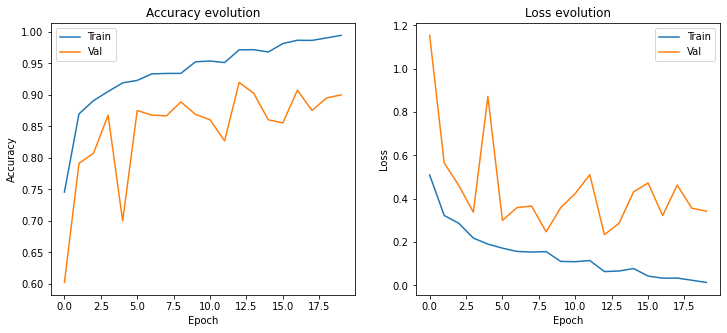

In [89]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(results_inception.history['accuracy'])
plt.plot(results_inception.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train','Val'])
plt.title('Accuracy evolution')

plt.subplot(122)
plt.plot(results_inception.history['loss'])
plt.plot(results_inception.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train','Val'])
plt.title('Loss evolution');

In [108]:
print('Classification report:')
Inception_pred = Inception_model.predict(Test_data)
print(classification_report(Inception_pred.round(),Test_label))

Classification report:
              precision    recall  f1-score   support

         0.0       0.79      0.99      0.88       187
         1.0       0.99      0.89      0.94       437

    accuracy                           0.92       624
   macro avg       0.89      0.94      0.91       624
weighted avg       0.93      0.92      0.92       624



# ResNet

The ResNet was introduced in 2015 by Kaiming He et al. in the [paper](https://arxiv.org/abs/1512.03385) entitled (Deep Residual Learning for Image Recognition). ResNet was the winner of the ILSVRC 2015 classification task. The main power of the ResNet is that it can go deeper than other architectures. It's reported in the previously mentioned paper that it goes 8x deeper than VGG nets while still maintaining lower complexity. This is basically due to the residual blocks which permits the ResNet to learn easilly learn the identity function, which permits the network to "hop over" or skip layers.

More details about the architecture can be found [here](https://towardsdatascience.com/introduction-to-resnets-c0a830a288a4).

The implementation of this architecture is also simplified in the following model (only 8 residual blocks), in order to maintain a reasonable complexity that can be handled using a local machine.

In [14]:
# function that will use the identity if possible, otherwise a projection of the number of filters
# in the input does not match the n_filters argument.

def residual_module(layer_in, n_filters):
    
    merge_input = layer_in
    if layer_in.shape[-1] != n_filters[2]:
        merge_input = Conv2D(n_filters[2], (1,1), padding='same', activation='relu', kernel_initializer='he_normal')(layer_in)
        
    conv1 = Conv2D(n_filters[0], (1,1), padding='same', activation='relu', kernel_initializer='he_normal')(layer_in)
    conv2 = Conv2D(n_filters[1], (3,3), padding='same', activation='relu', kernel_initializer='he_normal')(conv1)
    conv3 = Conv2D(n_filters[2], (1,1), padding='same', activation='linear', kernel_initializer='he_normal')(conv2)
    
    layer_out = add([conv3, merge_input])
    layer_out = Activation('relu')(layer_out)
    
    return layer_out

In [42]:
visible = Input(shape=(256,256,1))

layer = Conv2D(32, (7,7), strides=(2,2) ,padding='same', activation='relu', kernel_initializer='he_normal')(visible)
layer = MaxPooling2D((2,2), strides=2 ,padding='same')(layer)
layer = residual_module(layer, [8,8,16])
layer = residual_module(layer, [8,8,16])
layer = BatchNormalization()(layer)
layer = residual_module(layer, [8,8,16])
layer = residual_module(layer, [8,8,16])
layer = BatchNormalization()(layer)
layer = residual_module(layer, [16,16,32])
layer = residual_module(layer, [16,16,32])
layer = BatchNormalization()(layer)
layer = residual_module(layer, [32,32,64])
layer = residual_module(layer, [32,32,64])
layer = AveragePooling2D((3,3), padding='valid')(layer)
layer = Flatten()(layer)
layer = Dense(16, activation='relu')(layer)
layer = Dropout(0.1)(layer)
layer = Dense(1, activation='sigmoid')(layer)

ResNet_model = Model(inputs=visible, outputs=layer, name='ResNet_model')

ResNet_model.summary()

Model: "ResNet_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_184 (Conv2D)             (None, 128, 128, 32) 1600        input_8[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_12 (MaxPooling2D) (None, 64, 64, 32)   0           conv2d_184[0][0]                 
__________________________________________________________________________________________________
conv2d_186 (Conv2D)             (None, 64, 64, 8)    264         max_pooling2d_12[0][0]           
_______________________________________________________________________________________

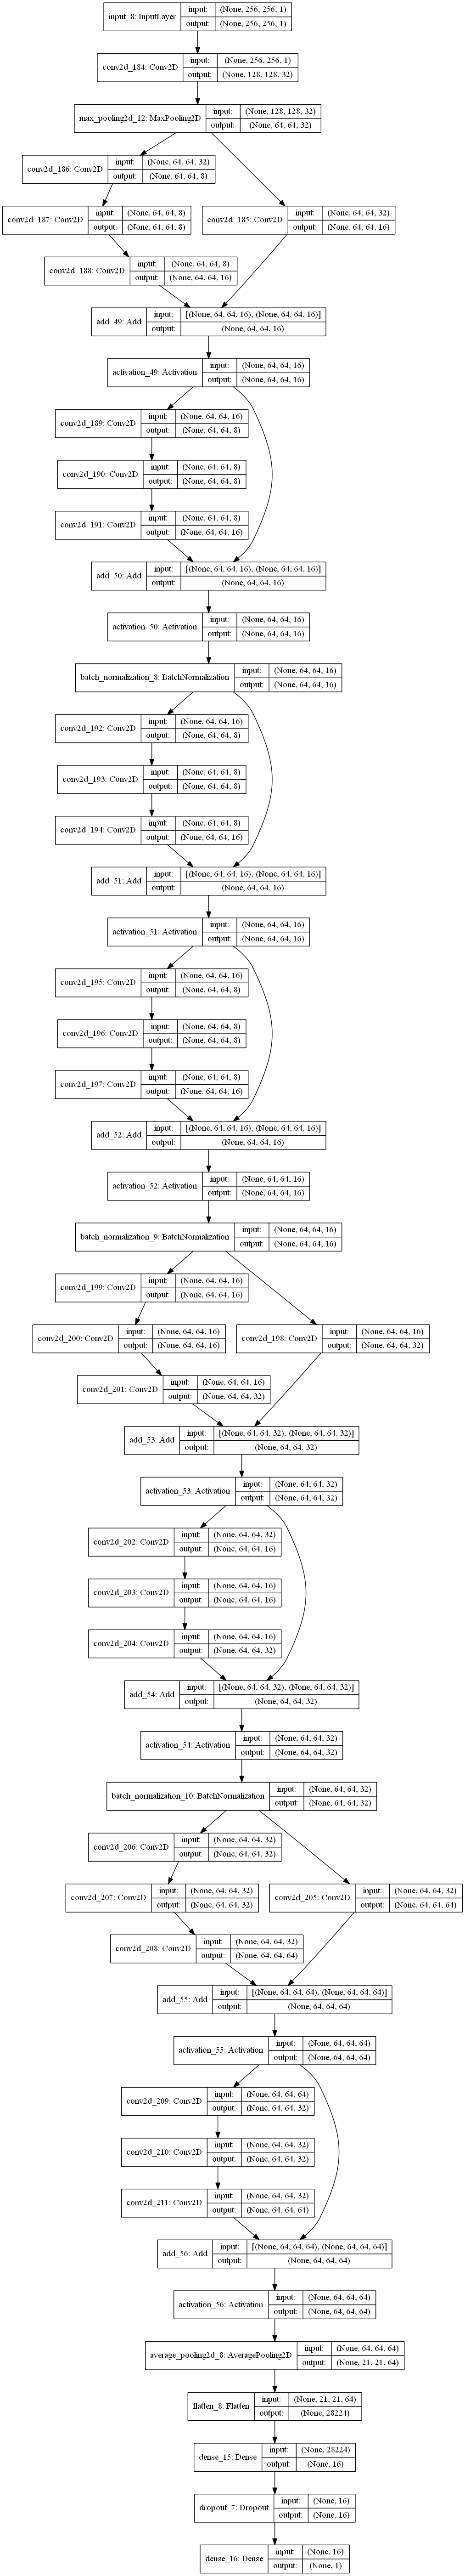

In [43]:
plot_model(ResNet_model, show_shapes=True, to_file='ResNet_module.png')

In [44]:
ResNet_model.compile(optimizer = 'adam', loss='binary_crossentropy', metrics=['accuracy'])
callback = ReduceLROnPlateau(monitor='val_loss', patience = 2, cooldown=0, verbose=1, factor=0.6, min_lr=0.000001)
start_ResNet = time()
results_ResNet = ResNet_model.fit(
    x=Train_data,
    y=Train_label,
    batch_size=16,
    validation_data=(Val_data,Val_label),
    class_weight={0:20, 1:0.5},
    epochs=15, callbacks=[callback])
end_ResNet = time()
ResNet_train_dur = end_ResNet - start_ResNet

Train on 15986 samples, validate on 810 samples
Epoch 1/15
15986/15986 [==============================] - 83s 5ms/step - loss: 0.7303 - accuracy: 0.7025 - val_loss: 4.7421 - val_accuracy: 0.5012
Epoch 2/15
15986/15986 [==============================] - 80s 5ms/step - loss: 0.4467 - accuracy: 0.7908 - val_loss: 0.7323 - val_accuracy: 0.6642
Epoch 3/15
15986/15986 [==============================] - 81s 5ms/step - loss: 0.3716 - accuracy: 0.8305 - val_loss: 0.8755 - val_accuracy: 0.6395
Epoch 4/15
15986/15986 [==============================] - 82s 5ms/step - loss: 0.3411 - accuracy: 0.8439 - val_loss: 0.5355 - val_accuracy: 0.7531
Epoch 5/15
15986/15986 [==============================] - 81s 5ms/step - loss: 0.3004 - accuracy: 0.8604 - val_loss: 0.5491 - val_accuracy: 0.7012
Epoch 6/15
15986/15986 [==============================] - 81s 5ms/step - loss: 0.2735 - accuracy: 0.8718 - val_loss: 0.6614 - val_accuracy: 0.7333

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0006000000

In [65]:
# Saving ResNet model

ResNet_model.save('./ResNet_model.h5')
with open('results_ResNet.pickle', 'wb') as file:
    pickle.dump(results_ResNet, file)

# Load the Inception trained model

ResNet_model = load_model('./ResNet_model.h5')
with open('results_ResNet.pickle', 'rb') as file:
     results_ResNet = pickle.load(file)

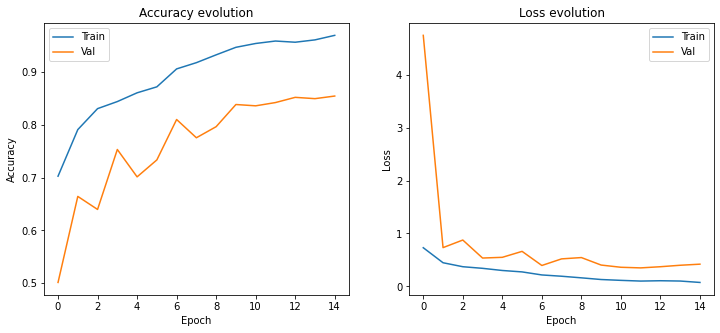

In [54]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(results_ResNet.history['accuracy'])
plt.plot(results_ResNet.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train','Val'])
plt.title('Accuracy evolution')

plt.subplot(122)
plt.plot(results_ResNet.history['loss'])
plt.plot(results_ResNet.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train','Val'])
plt.title('Loss evolution');

In [55]:
print('Classification report:')
ResNet_pred = ResNet_model.predict(Test_data)
print(classification_report(ResNet_pred.round(),Test_label))

Classification report:
              precision    recall  f1-score   support

         0.0       0.68      0.95      0.79       166
         1.0       0.98      0.83      0.90       458

    accuracy                           0.87       624
   macro avg       0.83      0.89      0.85       624
weighted avg       0.90      0.87      0.87       624



# Results

In this final section we're going to compare the results of the 3 trained models. 

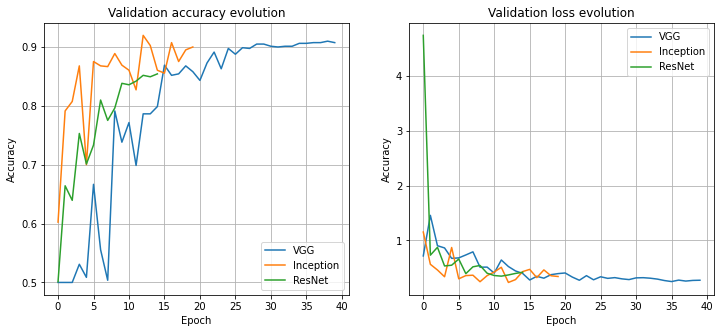

In [91]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(VGG_results.history['val_accuracy'])
plt.plot(results_inception.history['val_accuracy'])
plt.plot(results_ResNet.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['VGG','Inception','ResNet'])
plt.title('Validation accuracy evolution')
plt.grid(True)

plt.subplot(122)
plt.plot(VGG_results.history['val_loss'])
plt.plot(results_inception.history['val_loss'])
plt.plot(results_ResNet.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['VGG','Inception','ResNet'])
plt.title('Validation loss evolution')
plt.grid(True);

In [92]:
# Function to plot the confusion matrix of the trained model.

def plot_cm(mat,y_ture):
    df_cm = pd.DataFrame(mat, columns=np.unique(y_ture), index = np.unique(y_ture))
    df_cm.index.name = 'True Label'
    df_cm.columns.name = 'Predicted Label'
    sb.heatmap(df_cm, cmap="Blues", cbar=False, annot=True,annot_kws={"size": 10})
    plt.yticks(fontsize=10)
    plt.xticks(fontsize=10)

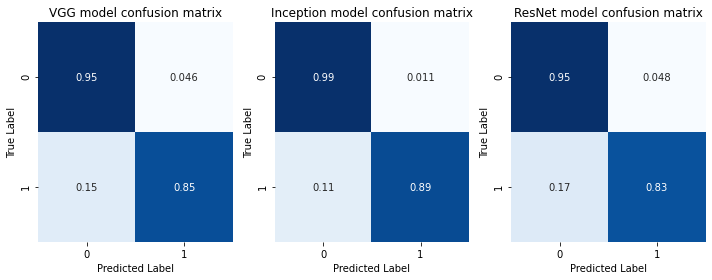

In [143]:
plt.figure(figsize=(10,4))
plt.subplot(131)
plot_cm(confusion_matrix(VGG_pred.round(),Test_label, normalize='true'), Test_label)
plt.title('VGG model confusion matrix')
plt.subplot(132)
plot_cm(confusion_matrix(Inception_pred.round(),Test_label, normalize='true'), Test_label)
plt.title('Inception model confusion matrix')
plt.subplot(133)
plot_cm(confusion_matrix(ResNet_pred.round(),Test_label, normalize='true'), Test_label)
plt.title('ResNet model confusion matrix')
plt.tight_layout()

In [140]:
VGG_rep = classification_report(VGG_pred.round(),Test_label, output_dict=True)
Inception_rep = classification_report(Inception_pred.round(),Test_label, output_dict=True)
ResNet_rep = classification_report(ResNet_pred.round(),Test_label, output_dict=True)


vgg_acc = round(VGG_rep['accuracy'],2)
inception_acc = round(Inception_rep['accuracy'],2)
resnet_acc = round(ResNet_rep['accuracy'],2)

vgg_normal_f1 = round(VGG_rep['0.0']['f1-score'],2)
inception_normal_f1 = round(Inception_rep['0.0']['f1-score'],2)
resnet_normal_f1 = round(ResNet_rep['0.0']['f1-score'],2)

vgg_pneu_f1 = round(VGG_rep['1.0']['f1-score'],2)
inception_pneu_f1 = round(Inception_rep['1.0']['f1-score'],2)
resnet_pneu_f1 = round(ResNet_rep['1.0']['f1-score'],2)


print('Comparaison of model results:')

result_table=[['Model','Training epochs' ,'Training duration (min)', 'Test accuracy', '(Normal) F1-score', '(Pneumonia) F1-score'],
             ['VGG model', 40, round(vgg_train_dur/60), vgg_acc, vgg_normal_f1, vgg_pneu_f1],
             ['Inception model', 20,round(inception_train_dur/60), inception_acc, inception_normal_f1, inception_normal_f1],
             ['ResNet model ', 15,round(ResNet_train_dur/60), resnet_acc, resnet_normal_f1, resnet_pneu_f1]]

display(HTML(tabulate.tabulate(result_table, colalign=("center",)*6, tablefmt='html')))

Comparaison of model results:


Model,Training epochs,Training duration (min),Test accuracy,(Normal) F1-score,(Pneumonia) F1-score
VGG model,40,77,0.88,0.82,0.91
Inception model,20,16,0.92,0.88,0.88
ResNet model,15,21,0.87,0.79,0.9


# Conclusion

In this pneumonia detection task, we've used three CNN architectures and compared their results. With very similar hyper-parameters, the inception architecture gave the best results on the test set. It's possible to increase the performance of these models by further optimizing the hyper-parameters and using more sophisticated callbacks, such as EarlyStopping.  